In [330]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import math
from numpy import concatenate
import datetime
from datetime import timedelta
import dateutil
import dateutil.parser
from matplotlib import pyplot
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
import requests
import seaborn as sns
import re
import oauth2 as oauth
from textblob import TextBlob
import tweepy
from tweepy import OAuthHandler
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from keras.layers import LSTM, Dense, Dropout 
from keras.models import Sequential

# Set Connections

In [331]:
# 2.Set Connecion


consumer = oauth.Consumer(key=consumer_key, secret=consumer_secret)
access_token_auth = oauth.Token(key=access_token, secret=access_token_secret)
client = oauth.Client(consumer, access_token_auth)

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token , access_token_secret )
api = tweepy.API(auth)

In [332]:
def new_table(start_time = '2022-01-18T00:00:00.000Z'):
    index = pd.date_range(start = dateutil.parser.isoparse(start_time).date(), end = datetime.datetime.now().date(), freq='D')
    columns = ['Twitter_Sentiment', 'Tweets_Number', 'Tweets_Acceleration',  'Volume', 'Price', '3_Day_MA', '5_Day_MA', '8_Day_MA','Tweets_Polyfit','Sentiment_Polyfit', 'Volume_Polyfit', "Price_Open"]
    df = pd.DataFrame(index=index, columns=columns)
    df = df.fillna(0)
    return df


# Create Tweet Growth Analysis

In [333]:
def tweet_number(dataset, start_time = '2022-01-18T00:00:00.000Z'):
    client = tweepy.Client(bearer_token='')

    # Replace with your own search query
    query = 'dogecoin -is:retweet'
    today = datetime.datetime.now()
    start_date = dateutil.parser.isoparse(start_time)
    delta = datetime.timedelta(days=29)
 
    while start_date.date() <= today.date():
        if start_date.date() + delta < today.date():
            end_date = start_date + delta
        else:
            end_date = today
        
        counts = client.get_all_tweets_count(query=query, granularity='day',start_time = start_date, end_time = end_date)

        for count in counts.data:
            tweet_date = dateutil.parser.isoparse(count["start"]).date()
            dataset.loc[str(tweet_date), 'Tweets_Number'] = int(count["tweet_count"])
            print(str(tweet_date))
        start_date += delta
    return dataset


# Create Tweet Sentiment

In [334]:
# Function to extract tweets
def get_tweets(Topic, end):
    # Create Columns of interest
    sentiment_df = pd.DataFrame(columns=["Tweet", "Date"])
    # Call Api
    tweets = tweepy.Cursor(api.search_tweets, q=Topic, count = 100, lang = "en", until = end).items(10)
    i=0
    #add tweet and date to new dataset
    for tweet in tweets:
        sentiment_df.loc[i] = [tweet.text,(tweet.created_at).date()]
        i = len(sentiment_df)
    return(sentiment_df)

In [335]:
def growth_multiplier(start_time = '2022-01-01T00:00:00.000Z'):
    client = tweepy.Client(bearer_token='')

    # Replace with your own search query
    query = 'dogecoin -is:retweet'
    today = datetime.datetime.now()
    start_date = dateutil.parser.isoparse(start_time)

    counts = client.get_all_tweets_count(query=query, granularity='hour',start_time = start_date, end_time = today)
    tweets_times = pd.DataFrame(columns = ['Hour', 'Count'])
    for count in counts.data:
        count["start"] = count["start"]
        tweet_hour = count["start"][11:13]
        tweets_times = tweets_times.append({'Hour': tweet_hour, 'Count': int(count["tweet_count"])}, ignore_index=True)
    tweets_times = tweets_times.groupby("Hour").mean()
    tweets_times = tweets_times.cumsum()
    tweets_times["Multiplier"] = tweets_times["Count"][-1]/tweets_times["Count"]
    tweets_times["Multiplier_Date_Adjust"] = tweets_times["Multiplier"].shift(periods=-5, fill_value=1)
    now = datetime.datetime.now()
    hour = now.strftime('%H')
    multiplier = tweets_times["Multiplier"][hour]
    multiplier_adj = tweets_times["Multiplier_Date_Adjust"][hour]

    return multiplier, multiplier_adj

# Analyze the tweets

In [336]:
# Function to Clean the Tweet.

def clean(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([RT])', ' ', str(tweet).lower()).split())


In [337]:
# Funciton to analyze Sentiment
def sentiment_analysis(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

In [338]:
#Put it all Together calls fucntion to get, clean and analyze sentiment
def twitter_sentiment(dataset, Topic="Dogecoin -is:retweet", end = "2022-01-24"):
    df = get_tweets(Topic, end)
    df['clean'] = df['Tweet'].apply(lambda x : clean(x))
    df["Sentiment"] = df["Tweet"].apply(lambda x : sentiment_analysis(x))
    Sentiment = df[["Sentiment", "Date"]]
    #Groupby tweets date by mean of sentiment
    Daily_Sentiment = Sentiment.groupby(Sentiment['Date']).mean().reset_index()
    #append to dataset
    for i in range(len(Daily_Sentiment)):
        dataset.loc[str(Daily_Sentiment["Date"][i]), 'Twitter_Sentiment'] = Daily_Sentiment["Sentiment"][i]
    return dataset
    

# Crypto Price Data

In [339]:
#Get Polygon API Data
def get_crypto_prices(dataset, start, end):
    api_key = ''
    #Create url that takes in start and end dates
    api_url = f'https://api.polygon.io/v2/aggs/ticker/X:DOGEUSD/range/1/day/{start}/{end}?unadjusted=true&sort=asc&apiKey={api_key}'
    #get json format and wrangle price date and volume 
    raw = requests.get(api_url).json()
    df = pd.DataFrame(raw['results'])[['t','c', 'v']]
    df = df.rename(columns = {'t':'Date','c':'Price', 'v':'Volume'})
    df["Date"] = pd.to_datetime(df["Date"], unit = 'ms')
    #this is only important for live version since polygon only allows end date data 
    # so to run before 4:30 pm EST we need to substitute dogecoins price with previous close
    #ideally get real time but fees cost 100$/m
    last_day_update = df.iloc[-1]['Price']
    #append
    for i in range(len(df)):
        dataset.loc[str(df["Date"][i]), 'Volume'] = df["Volume"][i]
        dataset.loc[str(df["Date"][i]), 'Price'] = df["Price"][i]
    return dataset, last_day_update

# LSTM Scaling & Transforming Data

In [340]:
#Create the preparation for the LSTM Model
def LSTM_Prep(dataset):

    #define training dataset this will later be partitioned into training and validation data
    training_dataset = dataset.copy()
    #remove dateindex for model creation, while previous days price should have an impact not the date
    datetime_column = training_dataset.index
    training_dataset = training_dataset.reset_index(drop=True).copy()

    #filtering variables and tables
    FEATURES = ['Twitter_Sentiment', 'Tweets_Number', 'Tweets_Acceleration', 
    'Volume', '3_Day_MA', '5_Day_MA', '8_Day_MA','Tweets_Polyfit',
    'Sentiment_Polyfit', 'Volume_Polyfit', "Price_Open", "Percent_Change"]

    data = pd.DataFrame(training_dataset)
    data_filtered = training_dataset.copy()
    data_filtered_ext = data_filtered[FEATURES]

    #rather than model price, we will be predicting change in price
    data_filtered_ext['Prediction'] = data_filtered_ext["Percent_Change"]

    #change data shape
    nrows = data_filtered.shape[0]
    np_data_unscaled = np.array(training_dataset)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    
    #normalizer creater
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

    #normalizer creater for prediction
    scaler_pred = MinMaxScaler()
    df_Close = pd.DataFrame(data_filtered_ext['Prediction'])
    np_Close_scaled = scaler_pred.fit_transform(df_Close)

    sequence_length = 50

    #create partition function
    def partition(sequence_length, data):
        x, y = [], []
        data_len = data.shape[0]
        for i in range(sequence_length, data_len):
            x.append(data[i-sequence_length:i,:]) 
            y.append(data[i, index_Close])
        
        x = np.array(x)
        y = np.array(y)
        return x, y

    #get prediction data index
    index_Close = data.columns.get_loc("Percent_Change")

    # Train Model on 80% of the data
    train_data_len = math.ceil(np_data_scaled.shape[0] * .8)

    # Split data in 80%
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]

    # Create testing and training data
    x_train, y_train = partition(sequence_length, train_data)
    x_test, y_test = partition(sequence_length, test_data)

    return x_train, y_train, x_test, y_test, datetime_column, scaler, scaler_pred, train_data_len, data_filtered

In [341]:
def LSTM_Model(x_train):
    #call model
    model = Sequential()

    # Model n_neurons = input shape with x_train.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    #add dense to each layer
    model.add(Dense(10))
    model.add(Dense(1))


    # Compile
    model.compile(optimizer='adam', loss='mse')
    return model

In [342]:
#Define model training
def LSTM_Train(x_train, y_train, x_test, y_test, model):
    #investigate loses to see if need more or less
    epochs = 20
    batch_size = 16
    history = model.fit(x_train, y_train, batch_size=batch_size, 
                        epochs=epochs,validation_data=(x_test, y_test)
                    )
    return history, epochs

In [343]:
# Plot training & validation loss values
def LSTM_history(history, epochs):
    fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
    plt.plot(history.history["loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()

In [344]:
def LSTM_Test(x_test, y_test, scaler_pred, model):
    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))


    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    return y_pred

In [345]:
def Plot_Model(y_pred, datetime_column, train_data_len, data_filtered):
    # How many days to display model
    display_start_date = pd.Timestamp('today') - timedelta(days=365)

    # Fix Datetime colums
    data_filtered_sub = data_filtered.copy()
    data_filtered_sub['Date'] = datetime_column
    data_filtered_sub["Date"] = pd.to_datetime(data_filtered_sub["Date"], format = '%Y-%m-%d')

    # Define Predictions and Actuals (Switch change of percentage to change of price)
    train = data_filtered_sub[:train_data_len + 1]
    valid = data_filtered_sub[train_data_len:]
    valid.insert(1, "Prediction", y_pred.ravel(), True)
    valid.insert(1, "Difference", (valid["Price"]* (valid["Prediction"])), True)
    valid.insert(1, "Predicted_Price", (valid["Price"]* (1 + valid["Prediction"])), True)

    # limit timeframe
    valid = valid[valid['Date'] > display_start_date]
    train = train[train['Date'] > display_start_date]
    valid.to_csv("Prediction.csv")

    # plot
    fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
    xt = train['Date']; yt = train[["Price"]]
    xv = valid['Date']; yv = valid[["Price", "Predicted_Price"]]
    plt.title("Predictions vs Actual Values", fontsize=20)
    plt.ylabel("Doge", fontsize=18)
    plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
    plt.plot(xv, yv["Predicted_Price"], color="#E91D9E", linewidth=2.0)
    plt.plot(xv, yv["Price"], color="black", linewidth=2.0)
    plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

    # # Create seperate bar plot with differences
    x = valid['Date']
    y = valid["Difference"]

    plt.bar(x, y, width=0.8, color="blue")
    plt.grid()
    plt.show()

In [346]:
def Predict_Tomorrow(dataset, scaler, model, scaler_pred):
    #set sequence length
    sequence_length = 50
    df_temp = dataset[-sequence_length:]
    new_df = df_temp

    N = sequence_length

    # Get todays closing price value and scale the data

    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)

    # Append last N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)

    # Reshape
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # PPrint Price and predicted
    price_today = np.round(new_df['Price'][-1], 5)
    predicted_price = price_today * (1 + np.round(pred_price_unscaled.ravel()[0], 5))
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    plus = '+'; minus = ''
    print(f'The price for "Dogecoin" at {datetime.date.today()} was {price_today}')
    print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

In [347]:
def main():
    #set dates
    start = "2022-01-19"
    end = "2022-01-25"
    #read in old data to limit requests to api
    df =  pd.read_csv("Check.csv", index_col="Date")
    #create new columns with needed variables
    dataset = []
    dataset = new_table(start_time = f'{start}T00:00:00.000Z')
    dataset = tweet_number(dataset, start_time = f'{start}T00:00:00.000Z')
    dataset = twitter_sentiment(dataset, Topic="Dogecoin -is:retweet", end = end)
    dataset, last_day_update = get_crypto_prices(dataset , start, end)
    #create multiplier for last day for volume and Tweet Number based on different timezones
    multiplier, multiplier_adj = growth_multiplier(start_time = '2022-01-01T00:00:00.000Z')
    dataset.at[str(dataset.index[-1]), "Tweets_Number"] = dataset.iloc[-1]['Tweets_Number']* multiplier_adj
    dataset.at[str(dataset.index[-1]), "Volume"] = dataset.iloc[-1]['Tweets_Number']* multiplier
    #fix end of date pricing
    
    #Limit Requests
    dataset["Twitter_Sentiment"] = 1
    #Fix datetimes between old and new rows
    df.index = pd.to_datetime(df.index)
    df = df.append(dataset)
    dataset = df
    #fix previous day price to make sure if ran before business close to update price to new one available
    if dataset.iloc[-2]['Price'] == dataset.iloc[-3]['Price']:
        dataset.at[str(dataset.index[-2]), "Price"] = last_day_update
    dataset.at[str(dataset.index[-1]), "Price"] = dataset.iloc[-2]['Price']
    #create moving averages
    dataset['3_Day_MA'] = dataset['Price'].rolling(3).mean()
    dataset['5_Day_MA'] = dataset['Price'].rolling(5).mean()
    dataset['8_Day_MA'] = dataset['Price'].rolling(8).mean()
    #create tweet acceleration,polyfits and price opens
    for i in range(len(dataset)-1):
        dataset.at[str(dataset.index[i+1]), 'Tweets_Acceleration'] = ((dataset.iloc[i+1]['Tweets_Number']-dataset.iloc[i]['Tweets_Number'])/dataset.iloc[i]['Tweets_Number'])
        dataset.at[str(dataset.index[i+1]), "Price_Open"] = (float(dataset.iloc[i]['Price'])+.001)
        if i >= 2:
            dataset.at[str(dataset.index[i+1]), "Percent_Change"] = (dataset.iloc[i]['Price']-dataset.iloc[i]['Price_Open'])/dataset.iloc[i]['Price_Open']
        if i >= 7:
            poly_fit_number = np.poly1d(np.polyfit(np.arange(7), dataset["Tweets_Number"][i-7:i].to_numpy(), 2))
            poly_fit_sent = np.poly1d(np.polyfit(np.arange(7),dataset["Twitter_Sentiment"][i-7:i].to_numpy(), 2))
            poly_fit_volume = np.poly1d(np.polyfit(np.arange(7), dataset["Volume"][i-7:i].to_numpy(), 2))
            dataset.loc[str(dataset.index[i+1]), "Tweets_Polyfit"] = np.polyval(poly_fit_number, 7)
            dataset.loc[str(dataset.index[i+1]), "Sentiment_Polyfit"] = np.polyval(poly_fit_sent, 7)
            dataset.loc[str(dataset.index[i+1]), "Volume_Polyfit"] = np.polyval(poly_fit_volume, 7)
    #fix datetime isses in dataset
    dataset.index.name = "Date"
    dataset.reset_index(drop = False, inplace = True)
    dataset["Date"] = dataset["Date"].astype(str)
    dataset.set_index("Date", inplace= True)
    dataset = dataset.fillna(0)
    #send dataset to file
    dataset.to_csv("Check.csv")
    #prep LSTM and define model
    x_train, y_train, x_test, y_test, datetime_column, scaler, scaler_pred, train_data_len, data_filtered = LSTM_Prep(dataset)
    model = LSTM_Model(x_train)
    history, epochs = LSTM_Train(x_train, y_train, x_test, y_test, model)
    #LSTM_history(history, epochs)
    #predict model
    y_pred = LSTM_Test(x_test, y_test, scaler_pred, model)
    Plot_Model(y_pred, datetime_column, train_data_len, data_filtered)
    Predict_Tomorrow(dataset, scaler, model, scaler_pred)
    return 

2022-01-19
2022-01-20
2022-01-21
2022-01-22
2022-01-23
2022-01-24
2022-01-25
Epoch 1/20
17/17 [==============================] - 12s 492ms/step - loss: 0.3484 - val_loss: 0.0065
Epoch 2/20
17/17 [==============================] - 7s 412ms/step - loss: 0.0055 - val_loss: 6.5630e-04
Epoch 3/20
17/17 [==============================] - 7s 429ms/step - loss: 0.0045 - val_loss: 9.9194e-04
Epoch 4/20
17/17 [==============================] - 8s 453ms/step - loss: 0.0042 - val_loss: 1.4633e-04
Epoch 5/20
17/17 [==============================] - 7s 441ms/step - loss: 0.0044 - val_loss: 2.9696e-04
Epoch 6/20
17/17 [==============================] - 8s 477ms/step - loss: 0.0045 - val_loss: 5.2355e-04
Epoch 7/20
17/17 [==============================] - 7s 438ms/step - loss: 0.0043 - val_loss: 5.4457e-04
Epoch 8/20
17/17 [==============================] - 6s 382ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 9/20
17/17 [==============================] - 7s 421ms/step - loss: 0.0043 - val_loss: 4.588

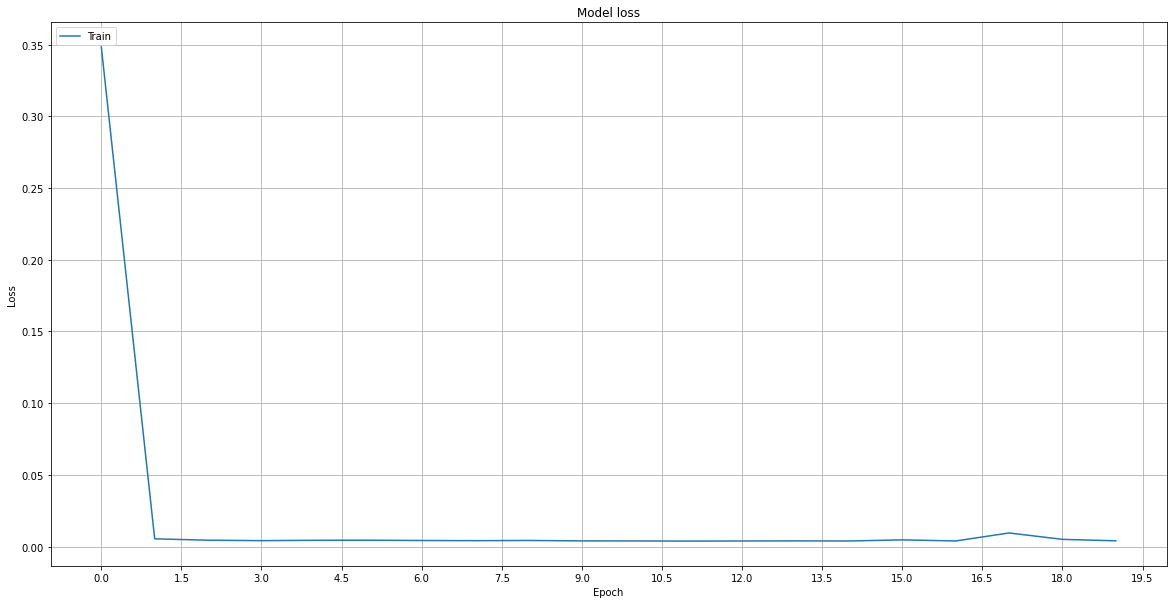

Median Absolute Error (MAE): 0.04
Mean Absolute Percentage Error (MAPE): 610.58 %
Median Absolute Percentage Error (MDAPE): 146.36 %


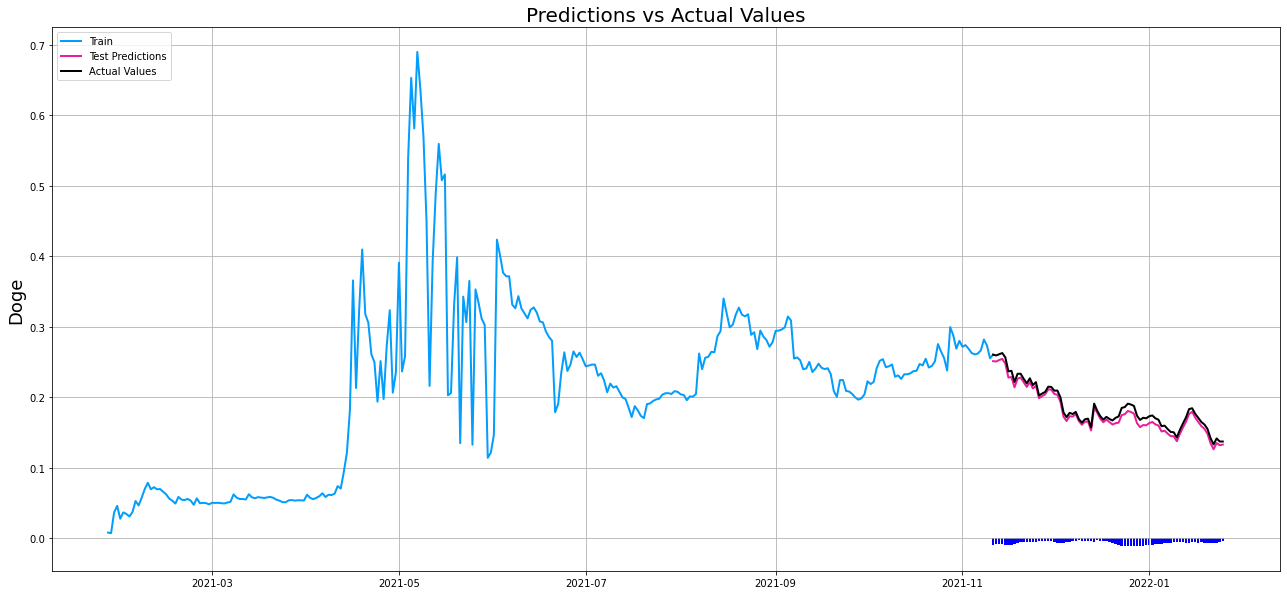

The close price for "Dogecoin" at 2022-01-25 was 0.1374
The predicted close price is 0.13394301603734493 (-2.58%)


In [348]:
main()